### Import Package

In [41]:
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import torch
import os
import random
from tqdm import tqdm as tqdm
from IPython import display
%matplotlib inline

from models.vgg import VGG_A
from models.vgg import VGG_A_BatchNorm
from data.loaders import get_cifar_loader


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 3060 Laptop GPU


In [43]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [44]:
num_workers = 4
batch_size = 128
train_loader, classes = get_cifar_loader(train=True)
val_loader, _ = get_cifar_loader(train=False)
print("classes:", classes)

Files already downloaded and verified
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Sample input: tensor([[[ 0.0196, -0.0039, -0.0275,  ...,  0.0196,  0.0275,  0.0039],
         [ 0.0510,  0.0275, -0.0275,  ...,  0.0824,  0.0353, -0.0039],
         [ 0.0196,  0.0275, -0.0196,  ...,  0.1529,  0.0902,  0.0275],
         ...,
         [-0.0510, -0.0510, -0.0588,  ..., -0.0431, -0.0275, -0.0275],
         [ 0.0039, -0.0118, -0.0275,  ...,  0.0196,  0.0118,  0.0118],
         [-0.0275, -0.0353, -0.0431,  ...,  0.0196, -0.0039, -0.0118]],

        [[ 0.1451,  0.1216,  0.0980,  ...,  0.1686,  0.1686,  0.1529],
         [ 0.1922,  0.1686,  0.1137,  ...,  0.2000,  0.1608,  0.1294],
         [ 0.1686,  0.1765,  0.1294,  ...,  0.2627,  0.2000,  0.1529],
         ...,
         [ 0.2706,  0.2706,  0.2627,  ...,  0.3255,  0.3412,  0.3333],
         [ 0.3255,  0.3020,  0.2941,  ...,  0.3804,  0.3725,  0.3647],
         [ 0.2784,  0.2706,  0.2627,  ...,  0.3725,  0.3490,  0.3255]],

        [[ 0.3804,  0.3569,  0.3333,  ...,  0.4118,  0.4196,  0.4118],
         [ 0.4275,  0.4039,  0.

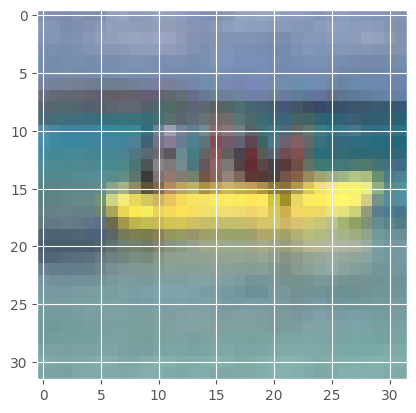

Successfully load data!


<Figure size 640x480 with 0 Axes>

In [45]:
for X, y in train_loader:
    print(f"Sample input: {X[0]}")
    print(f"Sample label: {y[0]}")
    print(f"Input shape: {X[0].shape}")
    print(f"Label shape: {y[0].shape}")
    print(f"Label: {classes[y[0]]}")
    img = np.transpose(X[0].cpu().numpy(), (1, 2, 0))
    plt.imshow(img * 0.5 + 0.5)
    plt.show()
    plt.savefig('sample1.png')
    print("Successfully load data!")
    break


In [46]:
def get_accuracy(model, data_loader, is_train=True):
    if is_train == False:
        model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    accuracy = correct / total
    if not is_train:
        print(f"Validation Accuracy: {accuracy:.4f} \n")
        model.train() 
    else:
        print(f"Train Accuracy: {accuracy:.4f} \n")
    return accuracy

In [ ]:
def train(model, optimizer, criterion, train_loader, val_loader, scheduler=None, epochs_num=100, duration=30, best_model_path=None):
    model.to(device)
    train_accuracy_curve = []
    val_accuracy_curve = []
    max_val_accuracy = 0
    iteration = 0

    for epoch in tqdm(range(epochs_num), unit='epoch', ncols=80):
        if scheduler is not None:
            scheduler.step()
        model.train()
        
        for data in train_loader:
            iteration += 1
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iteration % duration == 0:
                train_acc = get_accuracy(model, train_loader)
                val_acc = get_accuracy(model, val_loader, is_train=False)
                train_accuracy_curve.append(train_acc)
                val_accuracy_curve.append(val_acc)
                
                if val_acc > max_val_accuracy:
                    max_val_accuracy = val_acc
                    if best_model_path is not None:
                        torch.save(model.state_dict(), best_model_path)
    print(f'Training completed. The best validation accuracy: {max_val_accuracy}')
    return train_accuracy_curve, val_accuracy_curve


def plot_accuracy(train_acc, val_acc, model_name, save_path, color, duration=1): 
    steps = np.arange(0, len(train_acc)) * duration
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 5), dpi=850)
    plt.plot(steps, train_acc, color=f'{color}', linestyle='-', label=f'Training: {model_name}', linewidth=1)
    plt.plot(steps, val_acc, color=f'{color}', linestyle=':', label=f'Validation: {model_name}', linewidth=1)
    plt.title(f'The Accuracy Curve ({model_name})')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(save_path)  
    plt.show()              
    plt.close()    


### Train the VGG with batchnorm

In [48]:
epochs = 20
lr = 0.10
duration = 100
set_random_seeds(seed_value=0, device=device)

In [49]:
print(f'Training VGG-A without BatchNorm')
vgg_no_bn = VGG_A()
optimizer = torch.optim.SGD(vgg_no_bn.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
Loss = nn.CrossEntropyLoss()

os.makedirs('checkpoints', exist_ok=True)
tr_acc_no_bn, val_acc_no_bn = train(vgg_no_bn, optimizer, Loss, train_loader, val_loader, epochs_num=epochs, duration=duration, best_model_path='checkpoints/vgg_no_bn.pth')


Training VGG-A without BatchNorm


  0%|                                                 | 0/20 [00:00<?, ?epoch/s]

Train Accuracy: 0.2146 

Validation Accuracy: 0.2114 

Train Accuracy: 0.2555 

Validation Accuracy: 0.2554 

Train Accuracy: 0.3252 

Validation Accuracy: 0.3297 



  5%|██                                      | 1/20 [02:30<47:37, 150.39s/epoch]

Train Accuracy: 0.3139 

Validation Accuracy: 0.3213 

Train Accuracy: 0.3625 

Validation Accuracy: 0.3626 

Train Accuracy: 0.4062 

Validation Accuracy: 0.4035 

Train Accuracy: 0.4652 

Validation Accuracy: 0.4590 



 10%|████                                    | 2/20 [05:37<51:38, 172.15s/epoch]

Train Accuracy: 0.5343 

Validation Accuracy: 0.5215 

Train Accuracy: 0.5563 

Validation Accuracy: 0.5437 

Train Accuracy: 0.5559 

Validation Accuracy: 0.5457 

Train Accuracy: 0.6169 

Validation Accuracy: 0.5943 



 15%|██████                                  | 3/20 [08:48<51:13, 180.77s/epoch]

Train Accuracy: 0.6073 

Validation Accuracy: 0.5838 

Train Accuracy: 0.6188 

Validation Accuracy: 0.5901 

Train Accuracy: 0.6587 

Validation Accuracy: 0.6280 

Train Accuracy: 0.6611 

Validation Accuracy: 0.6352 



 20%|████████                                | 4/20 [12:01<49:26, 185.42s/epoch]

Train Accuracy: 0.7136 

Validation Accuracy: 0.6712 

Train Accuracy: 0.6602 

Validation Accuracy: 0.6259 

Train Accuracy: 0.6713 

Validation Accuracy: 0.6374 

Train Accuracy: 0.7064 

Validation Accuracy: 0.6644 



 25%|██████████                              | 5/20 [15:13<46:57, 187.83s/epoch]

Train Accuracy: 0.7305 

Validation Accuracy: 0.6837 

Train Accuracy: 0.7576 

Validation Accuracy: 0.7066 

Train Accuracy: 0.7191 

Validation Accuracy: 0.6799 

Train Accuracy: 0.7701 

Validation Accuracy: 0.7195 



 30%|████████████                            | 6/20 [18:26<44:13, 189.52s/epoch]

Train Accuracy: 0.7775 

Validation Accuracy: 0.7177 

Train Accuracy: 0.7726 

Validation Accuracy: 0.7109 

Train Accuracy: 0.8040 

Validation Accuracy: 0.7332 

Train Accuracy: 0.7731 

Validation Accuracy: 0.7130 



 35%|██████████████                          | 7/20 [21:39<41:19, 190.72s/epoch]

Train Accuracy: 0.8082 

Validation Accuracy: 0.7418 

Train Accuracy: 0.7736 

Validation Accuracy: 0.7111 

Train Accuracy: 0.8245 

Validation Accuracy: 0.7499 

Train Accuracy: 0.8132 

Validation Accuracy: 0.7401 



 40%|████████████████                        | 8/20 [24:46<37:55, 189.61s/epoch]

Train Accuracy: 0.8136 

Validation Accuracy: 0.7414 

Train Accuracy: 0.8274 

Validation Accuracy: 0.7476 

Train Accuracy: 0.8449 

Validation Accuracy: 0.7638 

Train Accuracy: 0.8078 

Validation Accuracy: 0.7343 



 45%|██████████████████                      | 9/20 [27:54<34:38, 188.96s/epoch]

Train Accuracy: 0.7945 

Validation Accuracy: 0.7193 

Train Accuracy: 0.7774 

Validation Accuracy: 0.6983 

Train Accuracy: 0.8273 

Validation Accuracy: 0.7428 

Train Accuracy: 0.8585 

Validation Accuracy: 0.7645 



 50%|███████████████████▌                   | 10/20 [31:05<31:35, 189.55s/epoch]

Train Accuracy: 0.8403 

Validation Accuracy: 0.7491 

Train Accuracy: 0.8338 

Validation Accuracy: 0.7439 

Train Accuracy: 0.8603 

Validation Accuracy: 0.7581 

Train Accuracy: 0.8578 

Validation Accuracy: 0.7655 



 55%|█████████████████████▍                 | 11/20 [34:17<28:34, 190.48s/epoch]

Train Accuracy: 0.8610 

Validation Accuracy: 0.7571 

Train Accuracy: 0.8655 

Validation Accuracy: 0.7679 

Train Accuracy: 0.8272 

Validation Accuracy: 0.7268 



 60%|███████████████████████▍               | 12/20 [36:50<23:52, 179.02s/epoch]

Train Accuracy: 0.8638 

Validation Accuracy: 0.7624 

Train Accuracy: 0.8653 

Validation Accuracy: 0.7612 

Train Accuracy: 0.8656 

Validation Accuracy: 0.7630 

Train Accuracy: 0.8851 

Validation Accuracy: 0.7731 



 65%|█████████████████████████▎             | 13/20 [40:03<21:23, 183.35s/epoch]

Train Accuracy: 0.8686 

Validation Accuracy: 0.7605 

Train Accuracy: 0.8409 

Validation Accuracy: 0.7348 

Train Accuracy: 0.8773 

Validation Accuracy: 0.7616 

Train Accuracy: 0.8726 

Validation Accuracy: 0.7595 



 70%|███████████████████████████▎           | 14/20 [43:13<18:32, 185.38s/epoch]

Train Accuracy: 0.8367 

Validation Accuracy: 0.7295 

Train Accuracy: 0.8870 

Validation Accuracy: 0.7769 

Train Accuracy: 0.8696 

Validation Accuracy: 0.7527 

Train Accuracy: 0.8727 

Validation Accuracy: 0.7617 



 75%|█████████████████████████████▎         | 15/20 [46:23<15:33, 186.74s/epoch]

Train Accuracy: 0.8845 

Validation Accuracy: 0.7681 

Train Accuracy: 0.8728 

Validation Accuracy: 0.7642 

Train Accuracy: 0.8870 

Validation Accuracy: 0.7637 

Train Accuracy: 0.8820 

Validation Accuracy: 0.7581 



 80%|███████████████████████████████▏       | 16/20 [49:34<12:31, 187.86s/epoch]

Train Accuracy: 0.8928 

Validation Accuracy: 0.7699 

Train Accuracy: 0.8695 

Validation Accuracy: 0.7562 

Train Accuracy: 0.8737 

Validation Accuracy: 0.7644 

Train Accuracy: 0.8859 

Validation Accuracy: 0.7649 



 85%|█████████████████████████████████▏     | 17/20 [52:49<09:30, 190.15s/epoch]

Train Accuracy: 0.8707 

Validation Accuracy: 0.7570 

Train Accuracy: 0.8834 

Validation Accuracy: 0.7682 

Train Accuracy: 0.8657 

Validation Accuracy: 0.7517 

Train Accuracy: 0.9013 

Validation Accuracy: 0.7748 



 90%|███████████████████████████████████    | 18/20 [55:59<06:20, 190.12s/epoch]

Train Accuracy: 0.8871 

Validation Accuracy: 0.7630 

Train Accuracy: 0.8844 

Validation Accuracy: 0.7600 

Train Accuracy: 0.8895 

Validation Accuracy: 0.7729 

Train Accuracy: 0.8912 

Validation Accuracy: 0.7682 



 95%|█████████████████████████████████████  | 19/20 [59:12<03:10, 190.89s/epoch]

Train Accuracy: 0.8797 

Validation Accuracy: 0.7586 

Train Accuracy: 0.8688 

Validation Accuracy: 0.7523 

Train Accuracy: 0.8907 

Validation Accuracy: 0.7670 

Train Accuracy: 0.8733 

Validation Accuracy: 0.7598 



100%|█████████████████████████████████████| 20/20 [1:02:23<00:00, 187.15s/epoch]

Training completed. The best validation accuracy: 0.7769


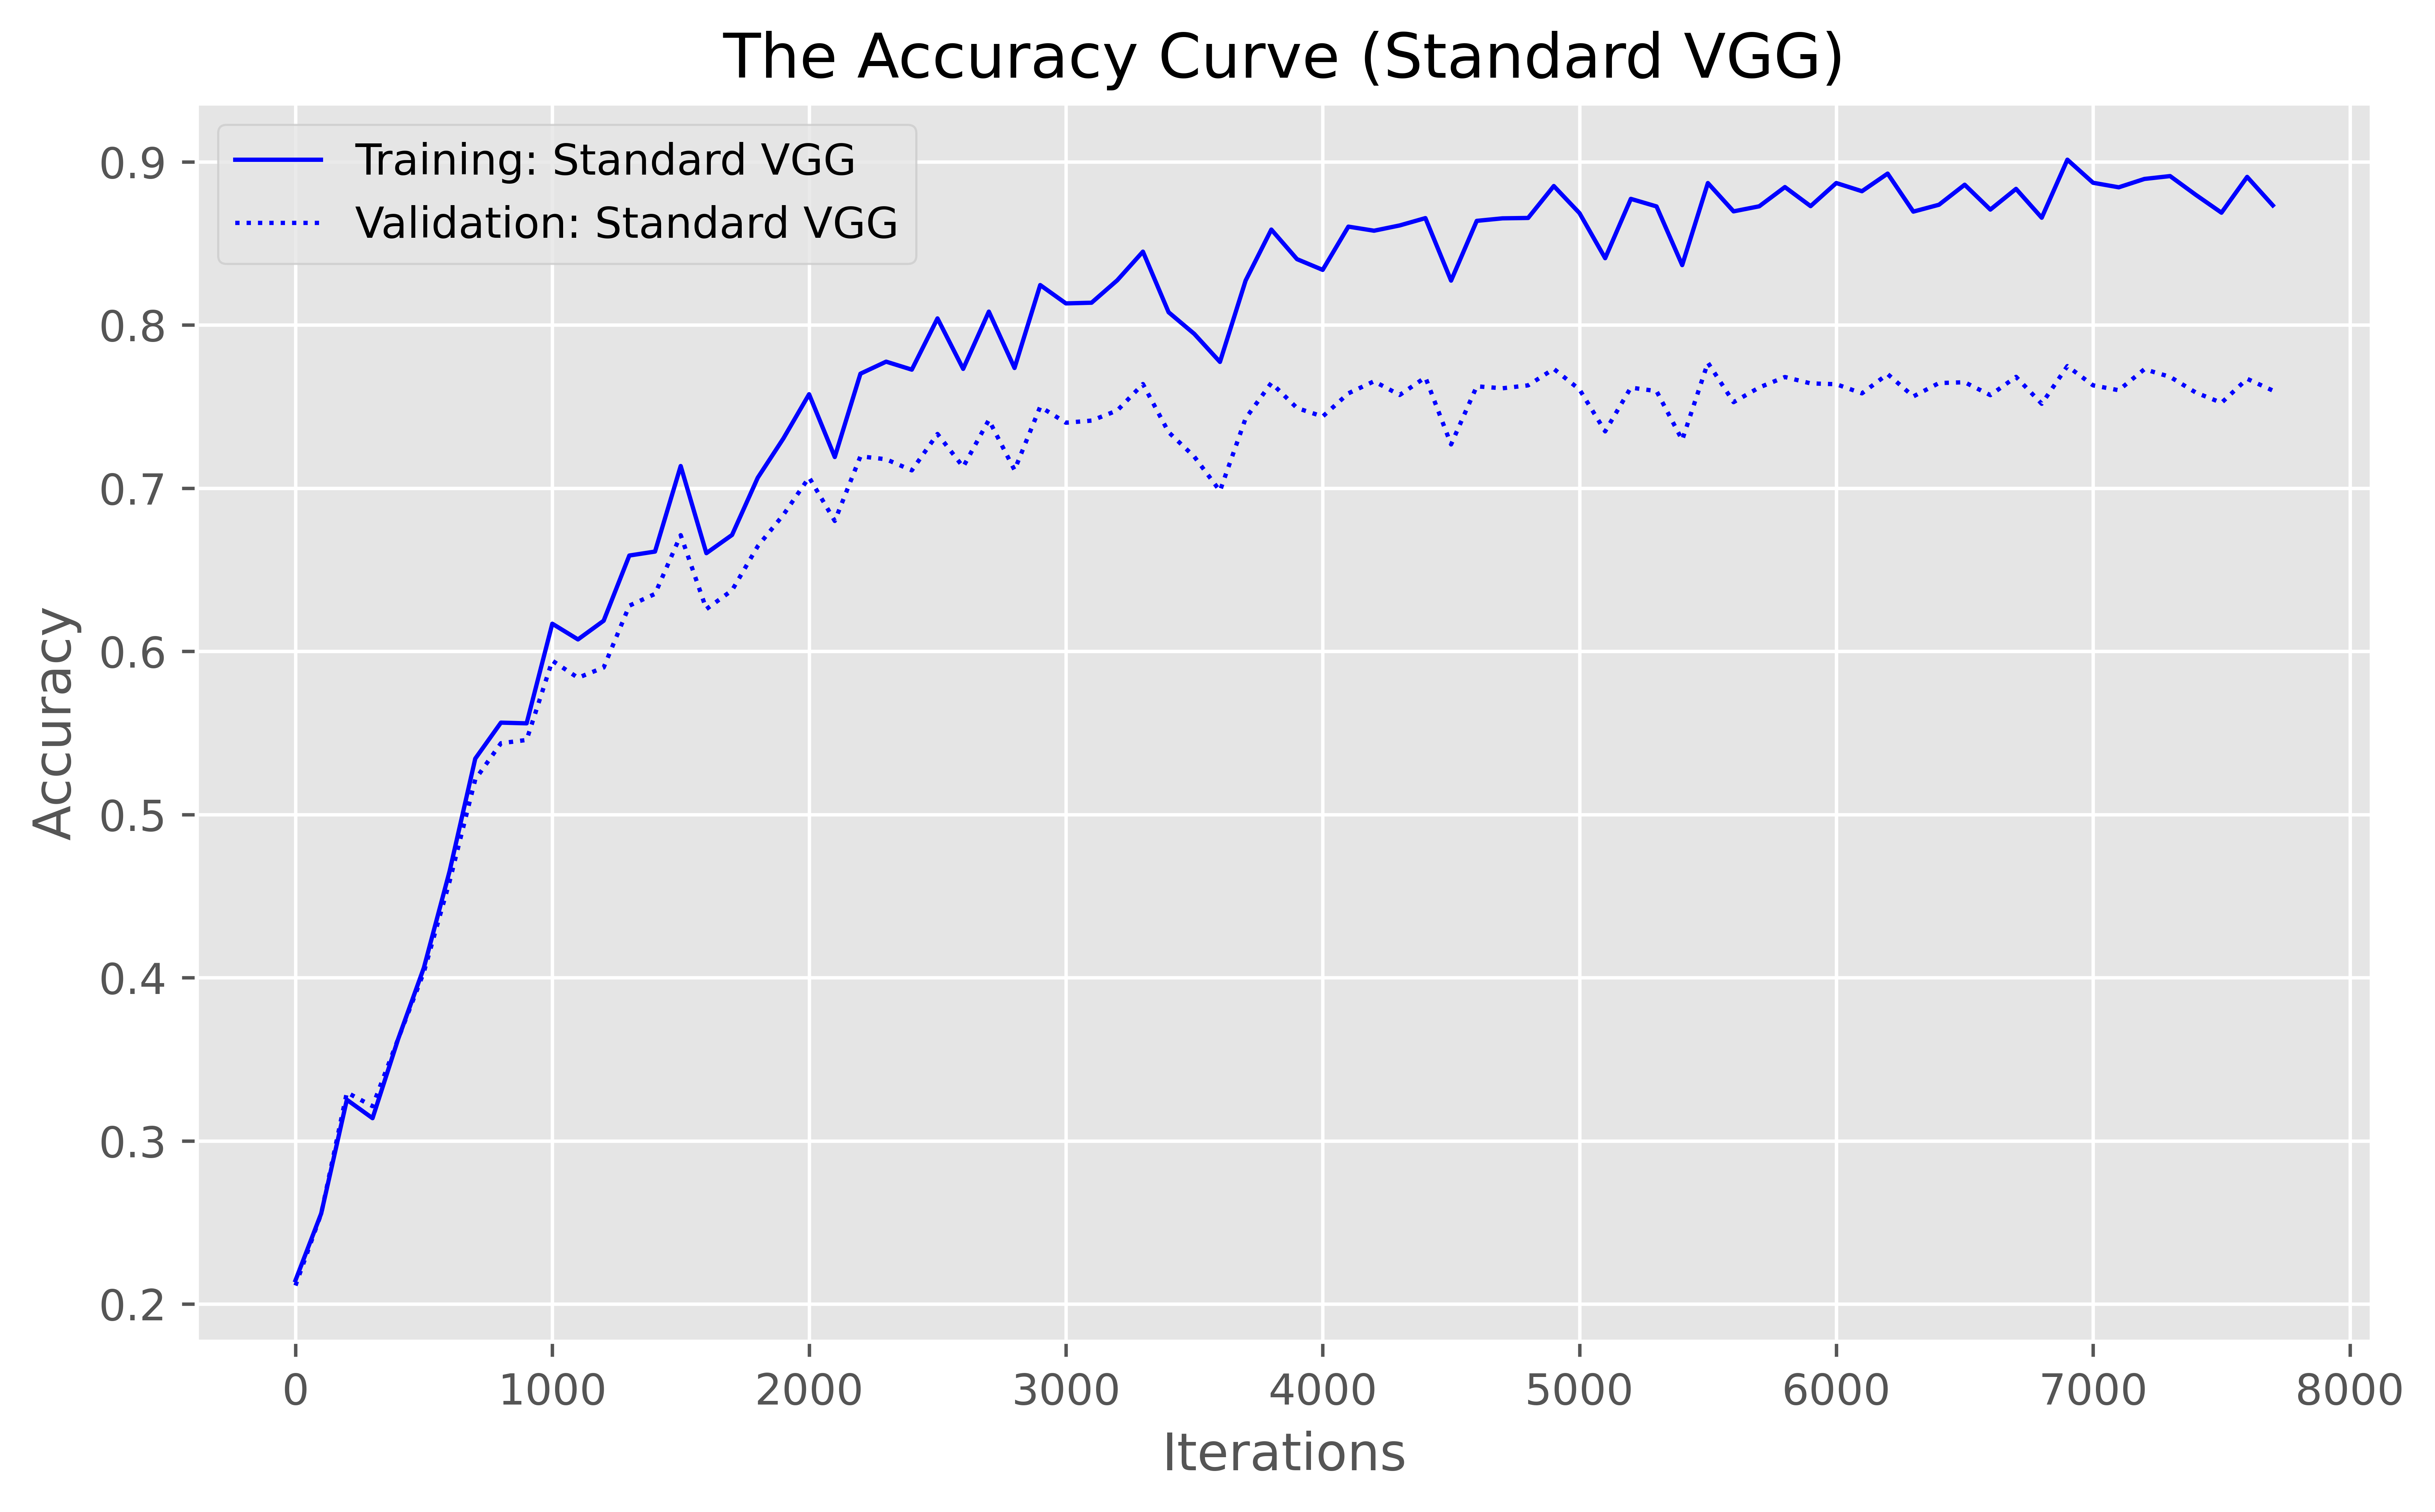

In [50]:
os.makedirs('./figs', exist_ok=True)
plot_accuracy(tr_acc_no_bn, val_acc_no_bn, 'Standard VGG', './figs/Standard_VGG_acc.png', "b", duration)

### Train the VGG without batchnorm

Training VGG-A with BatchNorm


  0%|                                                 | 0/20 [00:00<?, ?epoch/s]

Train Accuracy: 0.2597 

Validation Accuracy: 0.2756 

Train Accuracy: 0.3661 

Validation Accuracy: 0.3775 

Train Accuracy: 0.4065 

Validation Accuracy: 0.4137 



  5%|██                                      | 1/20 [02:32<48:10, 152.11s/epoch]

Train Accuracy: 0.4522 

Validation Accuracy: 0.4595 

Train Accuracy: 0.5026 

Validation Accuracy: 0.5023 

Train Accuracy: 0.5247 

Validation Accuracy: 0.5205 

Train Accuracy: 0.5831 

Validation Accuracy: 0.5828 



 10%|████                                    | 2/20 [05:44<52:45, 175.86s/epoch]

Train Accuracy: 0.6116 

Validation Accuracy: 0.6013 

Train Accuracy: 0.6172 

Validation Accuracy: 0.6098 

Train Accuracy: 0.6430 

Validation Accuracy: 0.6424 

Train Accuracy: 0.6697 

Validation Accuracy: 0.6607 



 15%|██████                                  | 3/20 [08:59<52:13, 184.35s/epoch]

Train Accuracy: 0.6898 

Validation Accuracy: 0.6732 

Train Accuracy: 0.6987 

Validation Accuracy: 0.6712 

Train Accuracy: 0.7252 

Validation Accuracy: 0.6968 

Train Accuracy: 0.7354 

Validation Accuracy: 0.7157 



 20%|████████                                | 4/20 [12:11<50:03, 187.72s/epoch]

Train Accuracy: 0.7640 

Validation Accuracy: 0.7319 

Train Accuracy: 0.7498 

Validation Accuracy: 0.7106 

Train Accuracy: 0.7636 

Validation Accuracy: 0.7289 

Train Accuracy: 0.7800 

Validation Accuracy: 0.7414 



 25%|██████████                              | 5/20 [15:24<47:22, 189.49s/epoch]

Train Accuracy: 0.7935 

Validation Accuracy: 0.7486 

Train Accuracy: 0.7995 

Validation Accuracy: 0.7557 

Train Accuracy: 0.7997 

Validation Accuracy: 0.7508 

Train Accuracy: 0.8182 

Validation Accuracy: 0.7546 



 30%|████████████                            | 6/20 [18:37<44:29, 190.70s/epoch]

Train Accuracy: 0.8154 

Validation Accuracy: 0.7547 

Train Accuracy: 0.8180 

Validation Accuracy: 0.7610 

Train Accuracy: 0.8341 

Validation Accuracy: 0.7763 

Train Accuracy: 0.8411 

Validation Accuracy: 0.7782 



 35%|██████████████                          | 7/20 [21:50<41:28, 191.40s/epoch]

Train Accuracy: 0.8435 

Validation Accuracy: 0.7725 

Train Accuracy: 0.8434 

Validation Accuracy: 0.7741 

Train Accuracy: 0.8551 

Validation Accuracy: 0.7755 

Train Accuracy: 0.8442 

Validation Accuracy: 0.7773 



 40%|████████████████                        | 8/20 [25:02<38:20, 191.71s/epoch]

Train Accuracy: 0.8537 

Validation Accuracy: 0.7775 

Train Accuracy: 0.8674 

Validation Accuracy: 0.7809 

Train Accuracy: 0.8742 

Validation Accuracy: 0.7910 

Train Accuracy: 0.8805 

Validation Accuracy: 0.7940 



 45%|██████████████████                      | 9/20 [28:14<35:10, 191.85s/epoch]

Train Accuracy: 0.8688 

Validation Accuracy: 0.7830 

Train Accuracy: 0.8675 

Validation Accuracy: 0.7860 

Train Accuracy: 0.8544 

Validation Accuracy: 0.7697 

Train Accuracy: 0.8770 

Validation Accuracy: 0.7906 



 50%|███████████████████▌                   | 10/20 [31:27<32:00, 192.09s/epoch]

Train Accuracy: 0.8799 

Validation Accuracy: 0.7876 

Train Accuracy: 0.8792 

Validation Accuracy: 0.7835 

Train Accuracy: 0.8842 

Validation Accuracy: 0.7908 

Train Accuracy: 0.9032 

Validation Accuracy: 0.8049 



 55%|█████████████████████▍                 | 11/20 [34:40<28:51, 192.34s/epoch]

Train Accuracy: 0.8925 

Validation Accuracy: 0.7965 

Train Accuracy: 0.8950 

Validation Accuracy: 0.8001 

Train Accuracy: 0.8921 

Validation Accuracy: 0.7892 



 60%|███████████████████████▍               | 12/20 [37:13<24:03, 180.38s/epoch]

Train Accuracy: 0.9030 

Validation Accuracy: 0.7989 

Train Accuracy: 0.8998 

Validation Accuracy: 0.8049 

Train Accuracy: 0.8983 

Validation Accuracy: 0.7961 

Train Accuracy: 0.9093 

Validation Accuracy: 0.8017 



 65%|█████████████████████████▎             | 13/20 [40:25<21:26, 183.78s/epoch]

Train Accuracy: 0.9186 

Validation Accuracy: 0.8067 

Train Accuracy: 0.8932 

Validation Accuracy: 0.7963 

Train Accuracy: 0.8962 

Validation Accuracy: 0.7948 

Train Accuracy: 0.8997 

Validation Accuracy: 0.7970 



 70%|███████████████████████████▎           | 14/20 [43:37<18:37, 186.28s/epoch]

Train Accuracy: 0.9150 

Validation Accuracy: 0.8017 

Train Accuracy: 0.9141 

Validation Accuracy: 0.8033 

Train Accuracy: 0.8920 

Validation Accuracy: 0.7863 

Train Accuracy: 0.9143 

Validation Accuracy: 0.8054 



 75%|█████████████████████████████▎         | 15/20 [46:49<15:40, 188.15s/epoch]

Train Accuracy: 0.9115 

Validation Accuracy: 0.7962 

Train Accuracy: 0.9109 

Validation Accuracy: 0.7992 

Train Accuracy: 0.9096 

Validation Accuracy: 0.8011 

Train Accuracy: 0.9278 

Validation Accuracy: 0.8088 



 80%|███████████████████████████████▏       | 16/20 [50:02<12:38, 189.57s/epoch]

Train Accuracy: 0.9302 

Validation Accuracy: 0.8110 

Train Accuracy: 0.9074 

Validation Accuracy: 0.7870 

Train Accuracy: 0.9041 

Validation Accuracy: 0.7836 

Train Accuracy: 0.9145 

Validation Accuracy: 0.8005 



 85%|█████████████████████████████████▏     | 17/20 [53:15<09:31, 190.53s/epoch]

Train Accuracy: 0.9197 

Validation Accuracy: 0.7998 

Train Accuracy: 0.9092 

Validation Accuracy: 0.7953 

Train Accuracy: 0.9054 

Validation Accuracy: 0.7887 

Train Accuracy: 0.9209 

Validation Accuracy: 0.8016 



 90%|███████████████████████████████████    | 18/20 [56:26<06:21, 190.74s/epoch]

Train Accuracy: 0.9274 

Validation Accuracy: 0.8022 

Train Accuracy: 0.9169 

Validation Accuracy: 0.7993 

Train Accuracy: 0.9093 

Validation Accuracy: 0.7869 

Train Accuracy: 0.9228 

Validation Accuracy: 0.8039 



 95%|█████████████████████████████████████  | 19/20 [59:38<03:11, 191.06s/epoch]

Train Accuracy: 0.9254 

Validation Accuracy: 0.8029 

Train Accuracy: 0.9074 

Validation Accuracy: 0.7914 

Train Accuracy: 0.9240 

Validation Accuracy: 0.8044 

Train Accuracy: 0.9279 

Validation Accuracy: 0.8086 



100%|█████████████████████████████████████| 20/20 [1:02:50<00:00, 188.51s/epoch]


Training completed. The best validation accuracy: 0.811


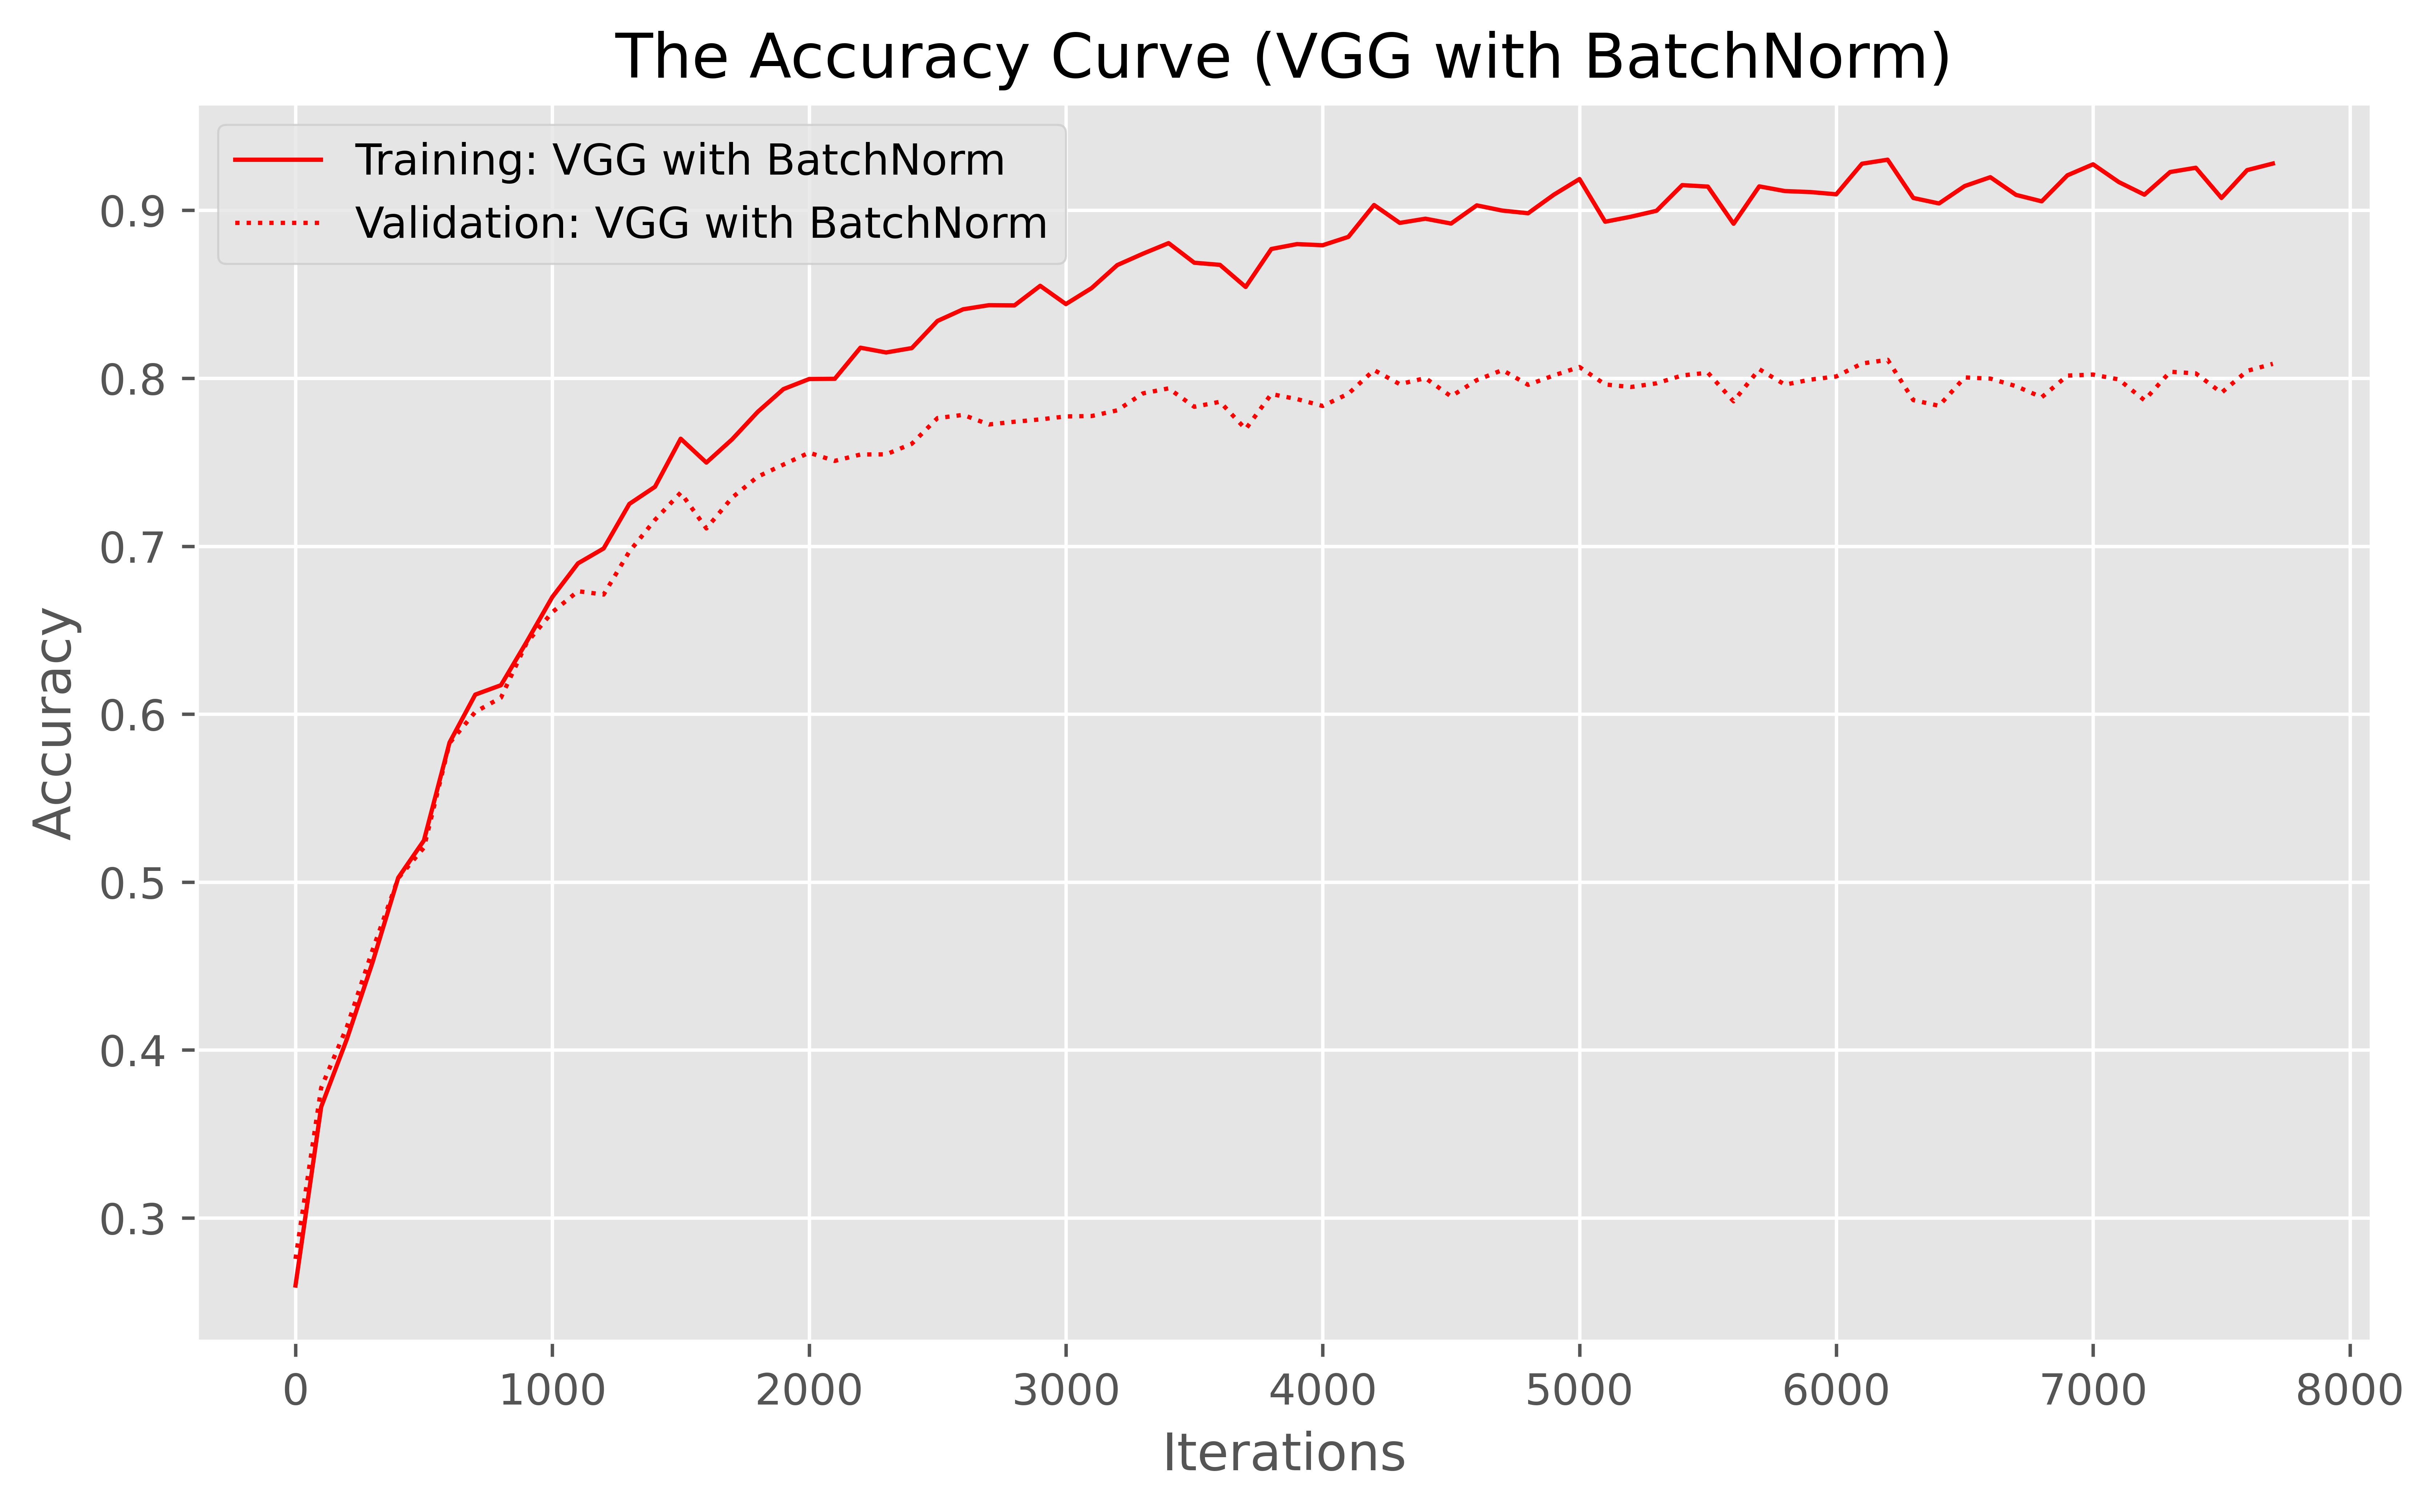

In [51]:
print(f'Training VGG-A with BatchNorm')
vgg_with_bn = VGG_A_BatchNorm()
optimizer = torch.optim.SGD(vgg_with_bn.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
Loss = nn.CrossEntropyLoss()
tr_acc_bn, val_acc_bn = train(vgg_with_bn, optimizer, Loss, train_loader, val_loader, epochs_num=epochs, duration=duration, best_model_path='checkpoints/vgg_with_bn.pth')
plot_accuracy(tr_acc_bn, val_acc_bn, 'VGG with BatchNorm', './figs/BatchNorm_VGG_acc.png', "r", duration)


### Comparision

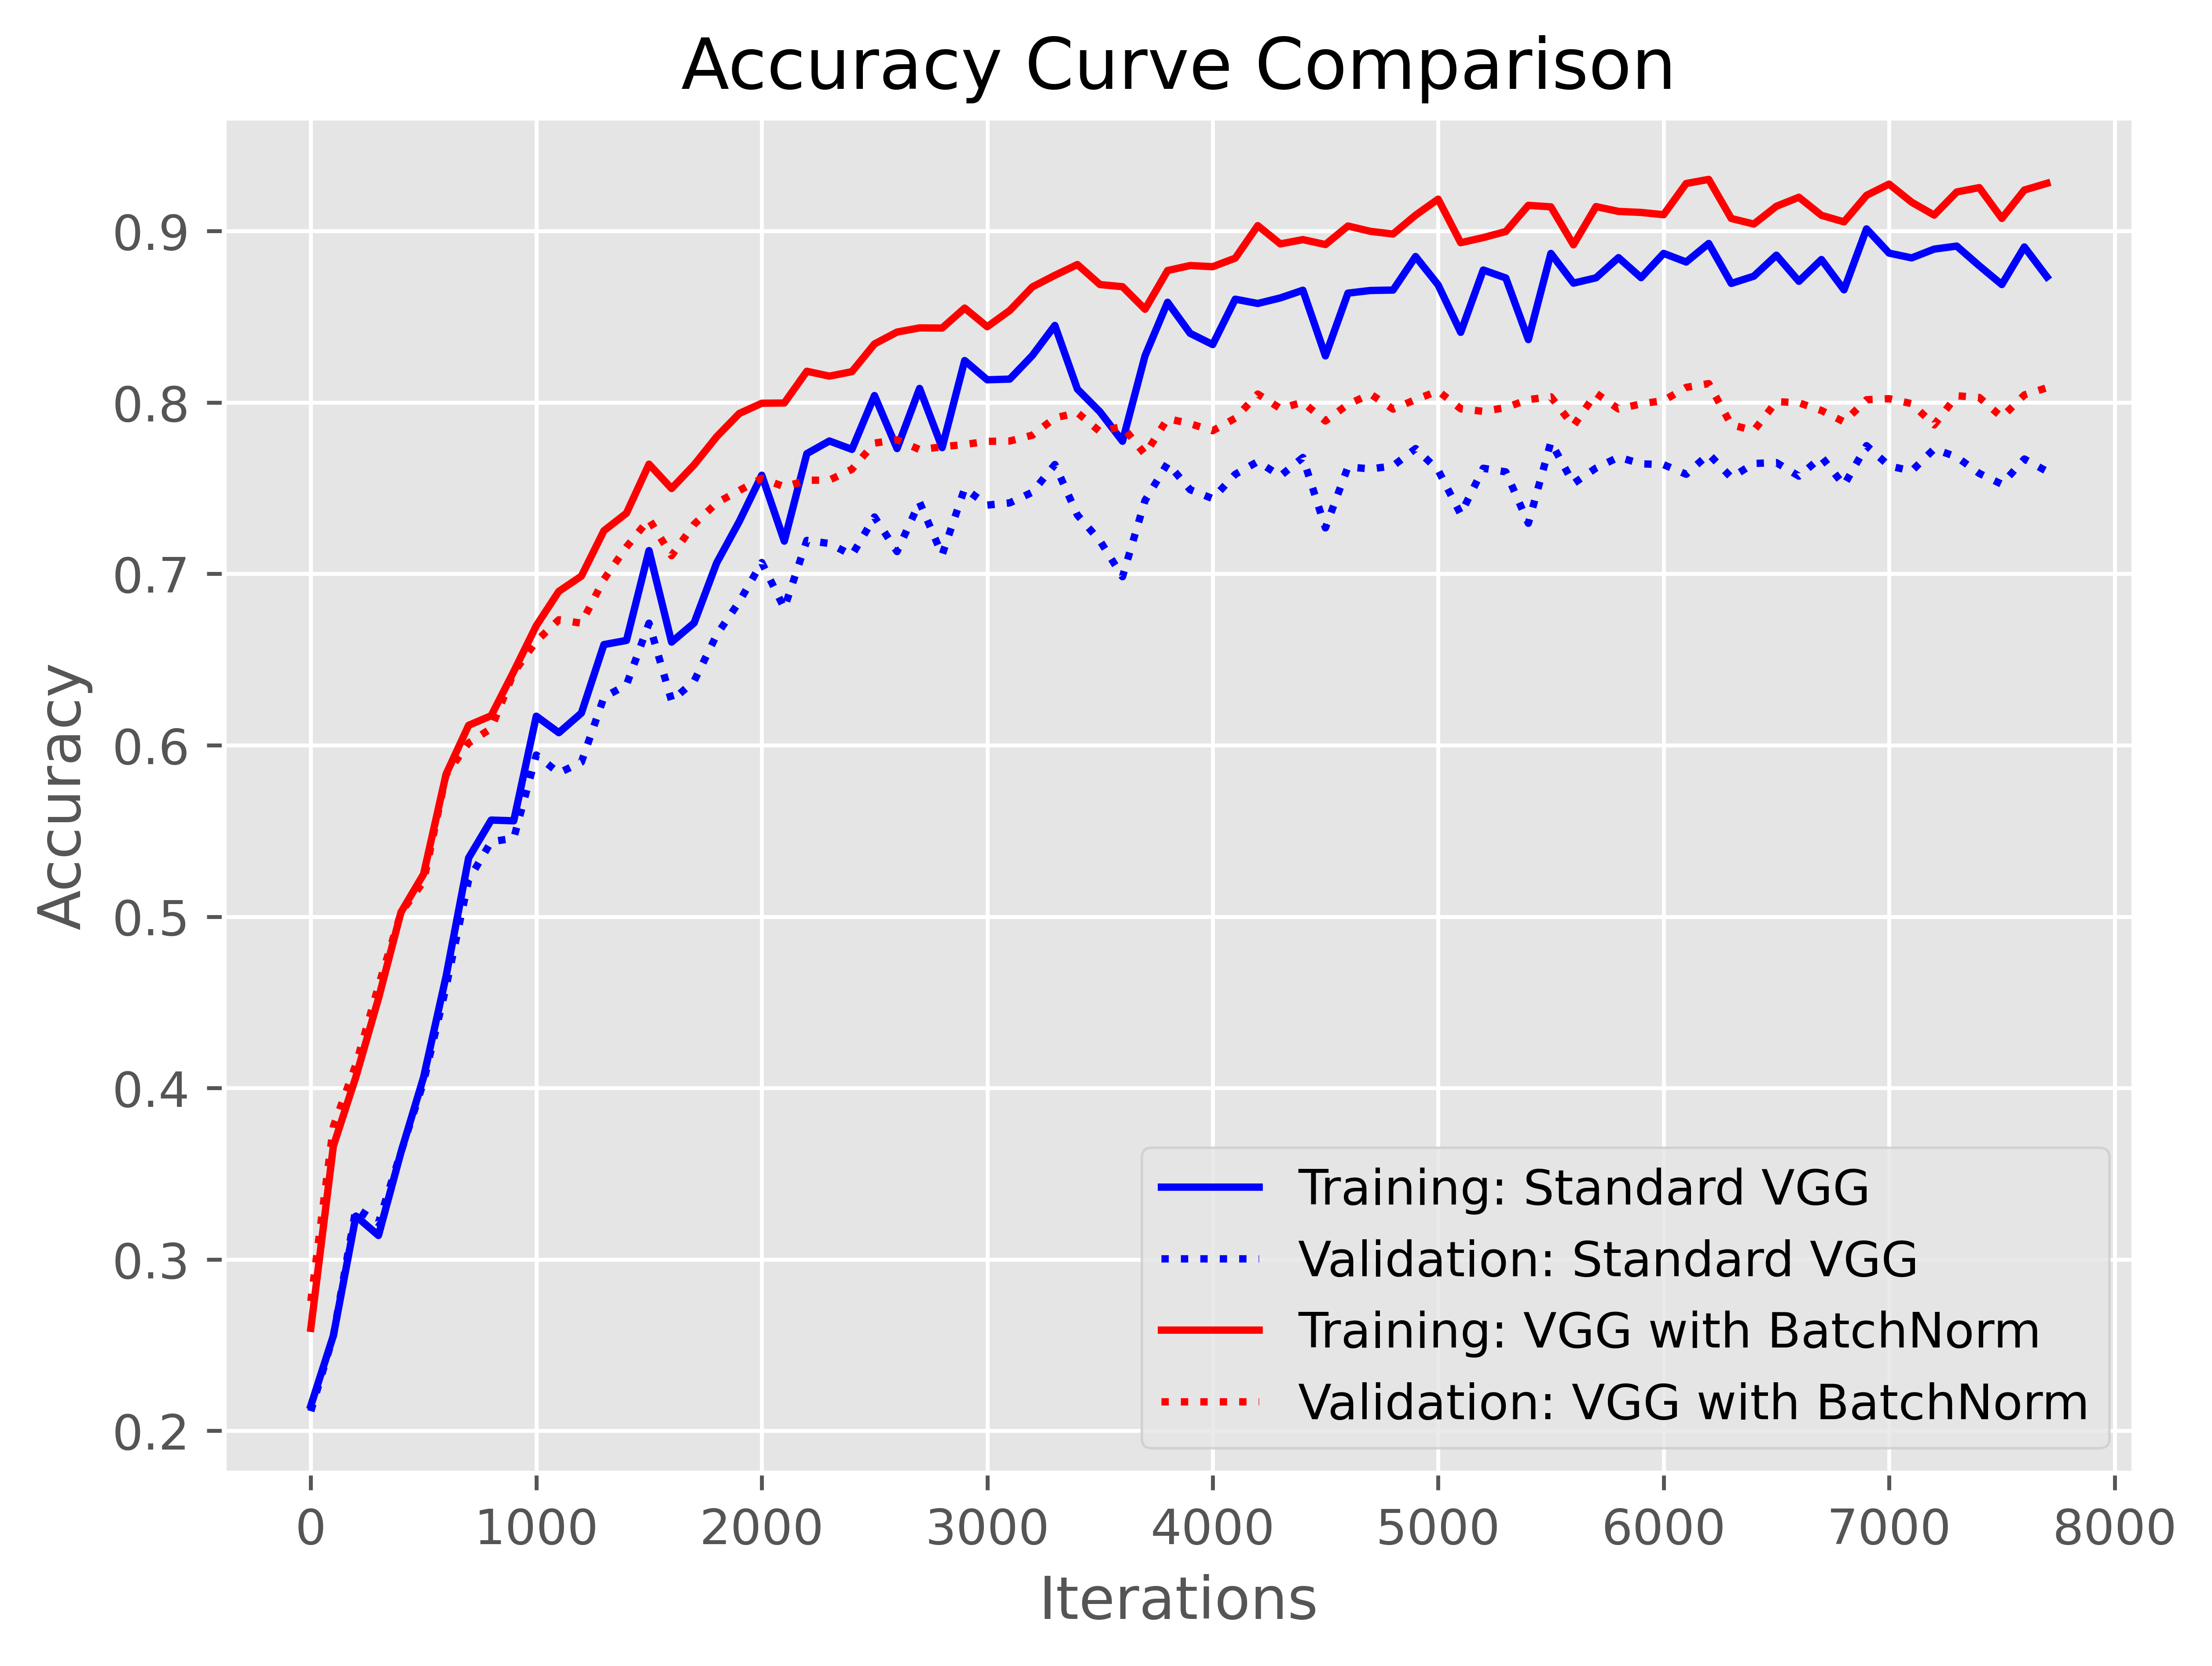

In [54]:

steps = np.arange(0, len(tr_acc_no_bn)) * duration
plt.style.use('ggplot')
plt.figure(figsize=(7, 5), dpi=800)
plt.plot(steps, tr_acc_no_bn, 'b-', label='Training: Standard VGG', linewidth=1.5)
plt.plot(steps, val_acc_no_bn, 'b:', label='Validation: Standard VGG', linewidth=1.5)
plt.plot(steps, tr_acc_bn, 'r-', label='Training: VGG with BatchNorm', linewidth=1.5)
plt.plot(steps, val_acc_bn, 'r:', label='Validation: VGG with BatchNorm', linewidth=1.5)
plt.title('Accuracy Curve Comparison')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('./figs/Comparison_acc.png')
plt.close()